<a href="https://colab.research.google.com/github/FinnHendricks/YOLO_ConeDetection/blob/Apply_TransferLearning/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FinnHendricks/YOLO_ConeDetection/blob/main/train.ipynb)

In [18]:
partial_dataset = True
load_model = False

# hosting gdrive not working as of 05.11.2021
"""from google.colab import drive
drive.mount('/content/gdrive')

model_path = "/content/gdrive/MyDrive/YOLO_cone/model"""

'from google.colab import drive\ndrive.mount(\'/content/gdrive\')\n\nmodel_path = "/content/gdrive/MyDrive/YOLO_cone/model'

In [19]:
%%capture

!gdown https://drive.google.com/uc?id=1OBJucC4oklE9-k4mZ5nQheoor6R548Tu
!unzip -u "/content/cones_multi_class_partial.zip" -d "/content/";

In [20]:
!pip install tensorflow-addons

In [21]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_addons as tfa
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD

import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

print(tf.config.list_physical_devices())
print(tf.__version__)

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.6.0
Fri Nov  5 14:58:30 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    32W / 250W |    863MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+----------------------------

In [22]:
%%capture
if partial_dataset:
    !unzip -u "/content/gdrive/MyDrive/cones_multi_class_partial.zip" -d "/content/";
    directory_train = '/content/cones_multi_class_partial/train/'
    directory_test = '/content/cones_multi_class_partial/test/'
    train_size = 128
    batch_size = 8
else:
    !unzip -u "/content/gdrive/MyDrive/cones_multi_class.zip" -d "/content/";
    directory_train = '/content/cones_multi_class/train/'
    directory_test = '/content/cones_multi_class/test/'
    train_size = 21_067 - 14  
    batch_size = 32

In [23]:

img_width = 512#800
img_height = 512#320
img_channels = 3

grid_X = 8
grid_Y = 8
num_classes = 7  # blue, yellow, orange_small, o_big, yellow, green, lying
anchor_size = num_classes + 5

epochs = 5
initial_learning_rate = 0.01
#final_learning_rate = 0.001
#learning_rate_decay_factor = (final_learning_rate / initial_learning_rate) ** (1/epochs)
steps_per_epoch = int(train_size/batch_size)


In [24]:
# convert the label given in the csv files to a matrix that can be used as y

def convert_label_to_y(label, file):
    object_class, x_center, y_center, width_bbox, height_bbox = list(map(float, label))

    # find relevant grid cell for predicting the object
    i, j = int(y_center * grid_Y), int(x_center * grid_X) # i row, j column 

    assert i < grid_Y, "center must be within the image" + str(file.name)
    assert j < grid_X, "center must be within the image" + str(file.name)

    x_center_bbox = x_center * grid_X - j  # find center relative to cell; 0...1
    y_center_bbox = y_center * grid_Y - i

    width_bbox *= grid_X  # scale box size, that 1 equals the grid size -> range of object size makes more sense
    height_bbox *= grid_Y

    c0, c1, c2, c3, c4, c5, c6 = tf.one_hot(tf.range(7), 7)[int(object_class)] # class of the cone
    # objectness, x_center, y_center, width_bbox, height_bbox, class0, c1, c2, c3, c4, c5, c6
    y = [1.0, x_center_bbox, y_center_bbox, width_bbox, height_bbox, c0, c1, c2, c3, c4, c5, c6]
    return y, i, j

In [25]:
black_list_files_train = ["00001505_skid-pad.txt", 
                    "Renningen_08_04_video_second_frame_8.txt", 
                    "Aidlingen_07_12_video_first_frame_4.txt",
                    "Aidlingen_07_12_video_first_frame_8.txt",
                    "upbracing-classes.txt",
                    "00001833_skid-pad.txt",
                    "00047.txt",
                    "Aidlingen_07_12_video_first_frame_7.txt",
                    "00001465_skid-pad.txt",
                    "Aidlingen_07_12_video_first_frame_5.txt",
                    "Aidlingen_07_12_video_first_frame_6.txt",
                    "213(2).txt",
                    "Aidlingen_07_12_video_first_frame_3.txt",
                    "00001464_skid-pad.txt"
                    ]  
                    # the labels of this samples are currupt and may not be used

black_list_files_test = []

def read_data(path, black_list_files=None):
    if black_list_files is None:
        black_list_files = []
    jpg_paths = []
    n_samples = 0
    for file in os.listdir(path):
        if file.endswith(".txt"):
            n_samples += 1
    n_samples -= len(black_list_files)

    sample_ctr = 0
    y = np.zeros((n_samples, grid_X, grid_Y, anchor_size))
    for file in os.listdir(path):
        if file.endswith(".txt"):
          
            if file in black_list_files:
                continue
            #try:
            with open(os.path.join(path, file), "r") as file:
                for label in file:
                    label = label.strip().split(" ")
                    cone, i, j = convert_label_to_y(label, file) 
                    
                    if y[sample_ctr, j, i, 0] == 0:
                        # no cone is stored at the grid cell, yet
                        y[sample_ctr, j, i, :] = cone
                    # else:
                        # slot already full- don´t write the cone
                        # print("No space to store the cone. Cone will be dismissed. File: ", file.name, i,j)
                        # think about dismissing the whole image and don´t use it for training
                        
            #except:
            #    print(str(file))
            #    continue
            #find the corresponding image path
            jpg_path = file.name.strip("txt")+"jpg"
            jpg_paths.append(jpg_path)
            sample_ctr += 1
            
    return jpg_paths, y

if partial_dataset:
    jpg_paths_train, y_train = read_data(directory_train)
    jpg_paths_test, y_test = read_data(directory_test)  
else:           
    jpg_paths_train, y_train = read_data(directory_train, black_list_files_train)
    jpg_paths_test, y_test = read_data(directory_test)
print(y_train.shape[0], " train images found.")
print(y_test.shape[0], " test images found.")



128  train images found.
32  test images found.


In [26]:
# input data

ds_train = tf.data.Dataset.from_tensor_slices((jpg_paths_train, y_train))
ds_test = tf.data.Dataset.from_tensor_slices((jpg_paths_test, y_test))

def read_image(image_file, y):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image, channels=3)#, dtype=tf.float32)
    return image, y

def resize(image, y):
    image = tf.image.resize(image, [img_height, img_width], method=tf.image.ResizeMethod.BILINEAR,preserve_aspect_ratio=False)
    # skip rescaling, because resnet expects int8
    #image = image / 255. # rescale
    return image, y


#ds_train = ds_train.map(read_image).map(resize_and_crop).map(augment).batch(batch_size)
ds_train = ds_train.map(read_image).map(resize).shuffle(train_size).batch(batch_size).prefetch(2)
ds_test = ds_test.map(read_image).map(resize).batch(batch_size)




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


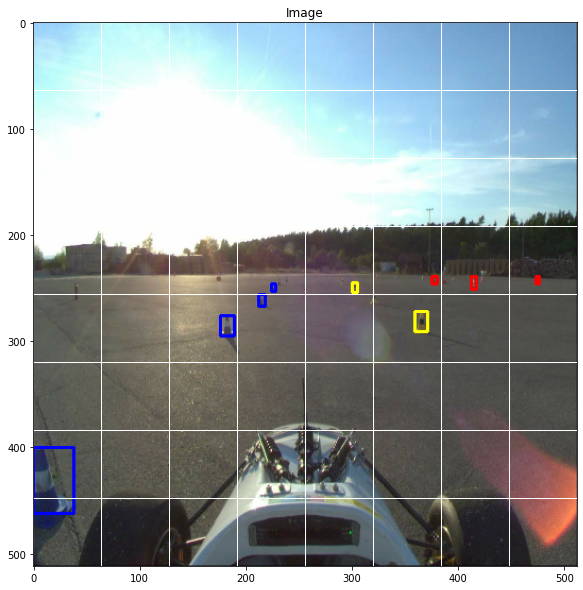

In [27]:
def visualize(image):
    fig = plt.figure(figsize=(10,10))
    plt.title('Image')
    plt.imshow(image)


def draw_bounding_box(image, y, draw_grid=True):
    image = image.numpy() / 255.
    h, w, _ = image.shape   
        
    relevant_grids = np.argwhere(y[:,:,0] >= 0.3)  # get relevant grids that contain objects with objectness > 0.3 
    for grid in relevant_grids:
        y_grid = y[grid[0], grid[1]]
        objectness, x_center_bbox, y_center_bbox, width_bbox, height_bbox = y_grid[:5]
        #blue, yellow, orange, orange-big, yellow-big, green, lying
        object_class = y_grid[5:]
        object_class = np.argmax(object_class) 

        #Todo: class when not 0 / 1
        colors = {
            0: [0, 0, 255],
            1: [255, 255, 0],
            2: [255, 165, 0],
            3: [255, 0  , 0],
            4: [255, 255, 255],
            5: [0  , 255, 0],
            6: [0  , 0  , 0]
        }
        color = colors[object_class]
        color = np.array(color) * objectness  # adjust brightness based on objectness

        color = tf.make_tensor_proto(color)
        color = tf.make_ndarray(color).astype(int).tolist()
    
        x_center = (x_center_bbox + grid[0])/grid_X*w
        y_center = (y_center_bbox + grid[1])/grid_Y*h
        box_width = width_bbox / grid_X * w
        box_height = height_bbox / grid_Y * h
        
        x_min = int(x_center - box_width/2)
        x_max = int(x_center + box_width/2)
        y_min = int(y_center - box_height/2)
        y_max = int(y_center + box_height/2)
        
        image = cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color, 2) 
    if draw_grid:
        grid_points = [[(int(i/grid_X*w), 0),(int(i/grid_X*w), h)]for i in range(grid_X)] + \
                      [[(0, int(i/grid_Y*h)),(w, int(i/grid_Y*h))]for i in range(grid_Y)]
        for points in grid_points: 
            cv2.line(image, points[0], points[1], [255, 255, 255], 1) 

    return image

for images, y in ds_train:
    #print(images.shape)
    i = np.random.randint(0, batch_size)
    image = draw_bounding_box(images[i], y[i].numpy(), draw_grid=True)
    visualize(image)
    break

In [28]:
base_model = keras.applications.ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(img_width, img_height, img_channels))
# base_model.summary()

base_model.trainable = False

input_layer = keras.layers.Input(shape=(img_width, img_height, img_channels), dtype=tf.uint8)
x = tf.cast(input_layer, tf.float32)
x = tf.keras.applications.resnet50.preprocess_input(x)
x = base_model(x)
x = keras.layers.MaxPool2D(pool_size=(2, 2))(x)
x = keras.layers.Conv2D(1024, (1, 1), strides=(1, 1), activation='relu', padding='same')(x)
x = keras.layers.Conv2D(256, (1, 1), strides=(1, 1), activation='relu', padding='same')(x)
out_channels = anchor_size  # 12
outputs = keras.layers.Conv2D(out_channels, (1, 1), strides=(1,1), activation='linear', padding='same')(x)



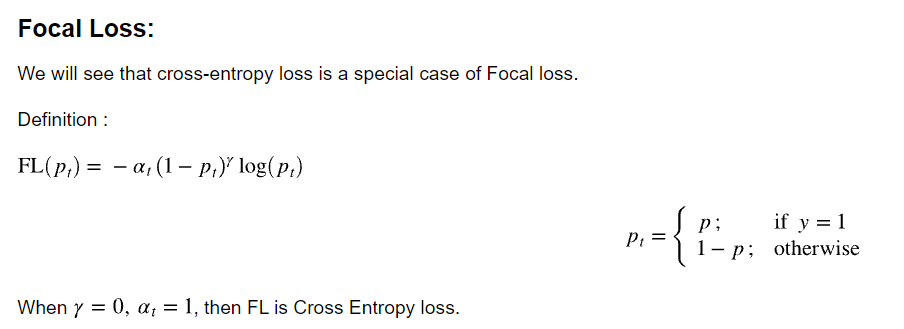

In [29]:

def loss_yolo_v1(y, y_pred):
    # objectness
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    mse = tf.keras.losses.MeanSquaredError()
    sfc = tfa.losses.SigmoidFocalCrossEntropy()
    # obj_weight = tf.ones_like(y[...,0])*0.1 + y[...,0]*10
    # obj_loss = bce(y[...,0], y_pred[...,0])*obj_weight
    obj_loss = mse(y, y_pred) #sfc(y[...,0], y_pred[...,0])
    loss = tf.reduce_sum(obj_loss) #+ tf.math.reduce_sum(box_loss)
    return loss

# Instantiate the model
if load_model:
    model = keras.models.load_model(model_path, custom_objects={'loss_yolo_v1': loss_yolo_v1})

else:
    model = keras.Model(inputs=input_layer, outputs=outputs)
    opt = keras.optimizers.Adam(learning_rate=0.01)
    model.compile(optimizer=opt, loss=loss_yolo_v1)

# print(model.summary())


model.fit(
    ds_train,
    epochs=10,
    verbose=2,
    # Only run validation using the first 10 batches of the dataset
    # using the `validation_steps` argument
    validation_data=ds_test,
    validation_steps=1
)
#model.save(model_path)

Epoch 1/10
16/16 - 23s - loss: 5139.0225 - val_loss: 0.0238
Epoch 2/10
16/16 - 4s - loss: 0.0357 - val_loss: 0.0202
Epoch 3/10
16/16 - 4s - loss: 0.0310 - val_loss: 0.0190
Epoch 4/10
16/16 - 4s - loss: 0.0300 - val_loss: 0.0193
Epoch 5/10
16/16 - 3s - loss: 0.0295 - val_loss: 0.0186
Epoch 6/10
16/16 - 4s - loss: 0.0293 - val_loss: 0.0187
Epoch 7/10
16/16 - 4s - loss: 0.0293 - val_loss: 0.0185
Epoch 8/10
16/16 - 4s - loss: 0.0292 - val_loss: 0.0194
Epoch 9/10
16/16 - 3s - loss: 0.0292 - val_loss: 0.0195
Epoch 10/10
16/16 - 4s - loss: 0.0289 - val_loss: 0.0187


In [30]:
opt = keras.optimizers.Adam(learning_rate=0.003)
model.compile(optimizer=opt, loss=loss_yolo_v1)
model.fit(
    ds_train,
    epochs=20,
    verbose=2,
    # Only run validation using the first 10 batches of the dataset
    # using the `validation_steps` argument
    validation_data=ds_test,
    validation_steps=1
)

Epoch 1/20
16/16 - 7s - loss: 0.0287 - val_loss: 0.0191
Epoch 2/20
16/16 - 4s - loss: 0.0271 - val_loss: 0.0248
Epoch 3/20
16/16 - 3s - loss: 0.0262 - val_loss: 0.0206
Epoch 4/20
16/16 - 3s - loss: 0.0253 - val_loss: 0.0320
Epoch 5/20
16/16 - 4s - loss: 0.0241 - val_loss: 0.0248
Epoch 6/20
16/16 - 3s - loss: 0.0231 - val_loss: 0.0260
Epoch 7/20
16/16 - 3s - loss: 0.0225 - val_loss: 0.0256
Epoch 8/20
16/16 - 3s - loss: 0.0215 - val_loss: 0.0404
Epoch 9/20
16/16 - 3s - loss: 0.0206 - val_loss: 0.0300
Epoch 10/20
16/16 - 3s - loss: 0.0195 - val_loss: 0.0320
Epoch 11/20
16/16 - 3s - loss: 0.0191 - val_loss: 0.0335
Epoch 12/20
16/16 - 3s - loss: 0.0191 - val_loss: 0.0251
Epoch 13/20
16/16 - 3s - loss: 0.0195 - val_loss: 0.0214
Epoch 14/20
16/16 - 3s - loss: 0.0190 - val_loss: 0.0317
Epoch 15/20
16/16 - 4s - loss: 0.0185 - val_loss: 0.0344
Epoch 16/20
16/16 - 3s - loss: 0.0178 - val_loss: 0.0273
Epoch 17/20
16/16 - 3s - loss: 0.0166 - val_loss: 0.0390
Epoch 18/20
16/16 - 4s - loss: 0.0159 - 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 512, 512, 3)


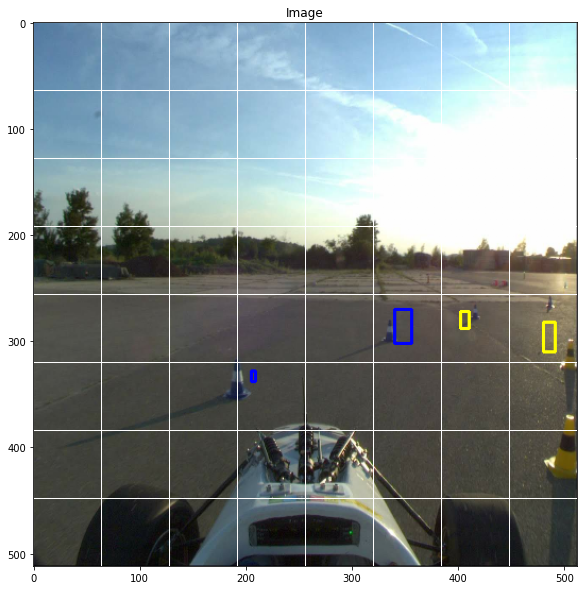

In [40]:
y_pred = 0
for images, y in ds_train:
    print(np.array([images[0]]).shape)
    y_pred = model.predict(np.array([images[0]])) 
    image = draw_bounding_box(images[0], y_pred[0], draw_grid=True)
    #image = draw_bounding_box(images[0], y[0], draw_grid=True)
    visualize(image)
    break




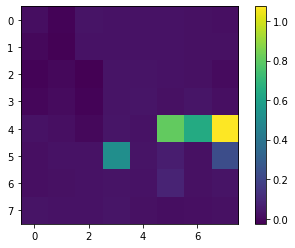

In [41]:
plt.imshow(y_pred[0,:,:,0].T)
plt.colorbar()

In [33]:
y.shape
x_center_bbox = y[...,1]
y_center_bbox = y[...,2]
box_width = y[...,3]
box_height = y[...,4]


x_min = x_center_bbox - box_width/2
x_max = x_center_bbox + box_width/2
y_min = y_center_bbox - box_height/2
y_max = y_center_bbox + box_height/2

box = tf.stack([y_min, x_min, y_max, x_max], axis=3)
box = tf.transpose(box, [3, 0, 1, 2])
box = tf.reshape(box, [4,-1])
box.shape

TensorShape([4, 512])

In [34]:
filename_show = directory_train + "00000001_low-pose_curves.txt"

y = np.zeros((8, grid_X, grid_Y, anchor_size))
with open(filename_show, "r") as file:
    for label in file:
        label = label.strip().split(" ")
        cone, i, j = convert_label_to_y(label, file) 
        
        if y[0, j, i, 0] == 0:
            # no cone is stored at the grid cell, yet
            y[0, j, i, :] = cone
y.shape

(8, 8, 8, 12)

In [35]:
jpg_show = filename_show.strip("txt")+"jpg"
ds_show = tf.data.Dataset.from_tensor_slices((jpg_show, y))
ds_show = ds_show.map().map(resize)


for images, y in show_img:
    #print(images.shape)
    i = np.random.randint(0, batch_size)
    image = draw_bounding_box(images[i], y[i], draw_grid=True)
    visualize(image)
    break

ValueError: ignored

In [ ]:
tf.where(tf.reshape(y[...,0], [-1]))

In [ ]:
tf.reshape(y[...,0], [-1])

In [ ]:
tf.where(tf.reshape(y[...,0], [-1]))[:,0]

In [ ]:
box = tf.gather(tf.reshape(y, [-1, 12]), tf.where(tf.reshape(y[...,0], [-1]))[:,0], axis=0)
print(box.shape)


x_center_bbox = box[:,1]
y_center_bbox = box[:,2]
box_width = box[:,3]
box_height = box[:,4]

x_min = x_center_bbox - box_width/2
x_max = x_center_bbox + box_width/2
y_min = y_center_bbox - box_height/2
y_max = y_center_bbox + box_height/2

In [ ]:
x_min

In [ ]:
x_max

In [ ]:
bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)
    mse = tf.keras.losses.MeanSquaredError()
    obj_weight = tf.ones_like(y[...,0])*0.01 + y[...,0]*100
    obj_loss = mse(y[...,0], y_pred[...,0])*obj_weight

    # bboxes as GIoU
    
    #box_loss = mse(y[...,1:5], y_pred[...,1:5])*box_weight

    x_center_bbox_pred = y_pred[...,1]
    y_center_bbox_pred = y_pred[...,2]
    box_width_pred = y_pred[...,3]
    box_height_pred = y_pred[...,4]

    x_center_bbox = y[...,1]
    y_center_bbox = y[...,2]
    box_width = y[...,3]
    box_height = y[...,4]

    x_min_pred = x_center_bbox_pred - box_width_pred/2
    x_max_pred = x_center_bbox_pred + box_width_pred/2
    y_min_pred = y_center_bbox_pred - box_height_pred/2
    y_max_pred = y_center_bbox_pred + box_height_pred/2

    x_min = x_center_bbox - box_width/2
    x_max = x_center_bbox + box_width/2
    y_min = y_center_bbox - box_height/2
    y_max = y_center_bbox + box_height/2

    box = tf.stack([y_min, x_min, y_max, x_max], axis=3)
    #print("1box", box.shape)
    #box = tf.transpose(box, [3, 0, 1, 2])
    #print("2box", box.shape)
    box = tf.reshape(box, [-1, 4])
    #print("3box", box.shape)

    box_pred = tf.stack([y_min_pred, x_min_pred, y_max_pred, x_max_pred], axis=3)
    #box_pred = tf.transpose(box_pred, [3, 0, 1, 2])
    box_pred = tf.reshape(box_pred, [-1, 4])
    
    # only use loss for bboxes where y has an objectness of 1

    #tf.print(box.shape)
    #tf.print(y[...,0].shape)
    #tf.print(tf.reshape(y[...,0], [-1]))#, tf.where(tf.reshape(y[...,0], -1))[:,0].shape)
    box = tf.gather(box, tf.where(tf.reshape(y[...,0], [-1]))[:,0], axis=0)
    box_pred = tf.gather(box_pred, tf.where(tf.reshape(y[...,0], [-1]))[:,0], axis=0)
    #tf.print("4box", box.shape)
    
    #tf.print("box_pred", box_pred.shape)
    gl = tfa.losses.GIoULoss()
    #tf.print("gl", gl)

    # input for GIoU: [y_min, x_min, y_max, x_max].
    #boxes1 = tf.constant([[0.0, 0.0, 1.0, 1.0]])#, [5.0, 6.0, 10.0, 7.0]])
    #boxes2 = tf.constant([[-5.0, -5.0, -2.0, -2.0]])#, [14.0, 14.0, 15.0, 15.0]])
    box_loss = gl(box, box_pred)
    #print("box loss", box_loss.shape)
    #print(loss)



    # classes
    ce = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
    class_pred = y_pred[...,5:]
    class_pred = tf.gather(class_pred, tf.where(tf.reshape(y[...,0], [-1]))[:,0], axis=0)
    class_true = y[...,5:]
    #tf.print(class_true.shape, class_true)
    class_pred = tf.gather(class_true, tf.where(tf.reshape(y[...,0], [-1]))[:,0], axis=0)
    #tf.print(class_true.shape, class_true)
    class_loss = ce(class_true, class_pred)

    loss = tf.math.reduce_sum(obj_loss) + tf.math.reduce_sum(box_loss) + tf.math.reduce_sum(class_loss)
  

In [ ]:
########################

## loss function storage

   

    """i, j = int(y_center * grid_Y), int(x_center * grid_X) # i row, j column 

    x_center_bbox = x_center * grid_X - j  # find center relative to cell; 0...1
    y_center_bbox = y_center * grid_Y - i

    width_bbox *= grid_X  # scale box size, that 1 equals the grid size -> range of object size makes more sense
    height_bbox *= grid_Y
    
    y = [1.0, x_center_bbox, y_center_bbox, width_bbox, height_bbox, c0, c1, c2, c3, c4, c5, c6]

    x_center = (x_center_bbox + grid[0])/grid_X*w
        y_center = (y_center_bbox + grid[1])/grid_Y*h
        box_width = width_bbox / grid_X * w
        box_height = height_bbox / grid_Y * h
        
        x_min = int(x_center - box_width/2)
        x_max = int(x_center + box_width/2)
    """
    # x_center is relative to the cell

    # objectness
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    mse = tf.keras.losses.MeanSquaredError()
    obj_weight = tf.ones_like(y[...,0])*0.1 + y[...,0]*10
    obj_loss = bce(y[...,0], y_pred[...,0])*obj_weight

    # bboxes as GIoU
    
    #box_loss = mse(y[...,1:5], y_pred[...,1:5])*box_weight

    x_center_bbox_pred = y_pred[...,1]
    y_center_bbox_pred = y_pred[...,2]
    box_width_pred = y_pred[...,3]
    box_height_pred = y_pred[...,4]

    x_center_bbox = y[...,1]
    y_center_bbox = y[...,2]
    box_width = y[...,3]
    box_height = y[...,4]

    x_min_pred = x_center_bbox_pred - box_width_pred/2
    x_max_pred = x_center_bbox_pred + box_width_pred/2
    y_min_pred = y_center_bbox_pred - box_height_pred/2
    y_max_pred = y_center_bbox_pred + box_height_pred/2

    x_min = x_center_bbox - box_width/2
    x_max = x_center_bbox + box_width/2
    y_min = y_center_bbox - box_height/2
    y_max = y_center_bbox + box_height/2

    box = tf.stack([y_min, x_min, y_max, x_max], axis=3)
    #print("1box", box.shape)
    #box = tf.transpose(box, [3, 0, 1, 2])
    #print("2box", box.shape)
    box = tf.reshape(box, [-1, 4])
    #print("3box", box.shape)

    box_pred = tf.stack([y_min_pred, x_min_pred, y_max_pred, x_max_pred], axis=3)
    #box_pred = tf.transpose(box_pred, [3, 0, 1, 2])
    box_pred = tf.reshape(box_pred, [-1, 4])
    
    # only use loss for bboxes where y has an objectness of 1

    #tf.print(box.shape)
    #tf.print(y[...,0].shape)
    #tf.print(tf.reshape(y[...,0], [-1]))#, tf.where(tf.reshape(y[...,0], -1))[:,0].shape)
    box = tf.gather(box, tf.where(tf.reshape(y[...,0], [-1]))[:,0], axis=0)
    box_pred = tf.gather(box_pred, tf.where(tf.reshape(y[...,0], [-1]))[:,0], axis=0)
    #tf.print("4box", box.shape)
    
    #tf.print("box_pred", box_pred.shape)
    gl = tfa.losses.GIoULoss()
    #tf.print("gl", gl)

    # input for GIoU: [y_min, x_min, y_max, x_max].
    #boxes1 = tf.constant([[0.0, 0.0, 1.0, 1.0]])#, [5.0, 6.0, 10.0, 7.0]])
    #boxes2 = tf.constant([[-5.0, -5.0, -2.0, -2.0]])#, [14.0, 14.0, 15.0, 15.0]])
    box_loss = gl(box, box_pred)
    #print("box loss", box_loss.shape)
    #print(loss)



    # classes
    ce = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
    class_pred = y_pred[...,5:]
    class_pred = tf.gather(class_pred, tf.where(tf.reshape(y[...,0], [-1]))[:,0], axis=0)
    class_true = y[...,5:]
    #tf.print(class_true.shape, class_true)
    class_pred = tf.gather(class_true, tf.where(tf.reshape(y[...,0], [-1]))[:,0], axis=0)
    #tf.print(class_true.shape, class_true)
    class_loss = ce(class_true, class_pred)

    loss = tf.math.reduce_sum(obj_loss) #+ tf.math.reduce_sum(box_loss) + tf.math.reduce_sum(class_loss)
    # -----------------------------------------------------------------------

    # first, find a mapping for each grid cell, which anchor 
    # objectness for each grid cell -> required to surpress ghost objects


    # x/y/w/h as GIoU only where y_pred has an object
    # select which bbox_pred belongs to which bbox_true based on minimizing the overall GIoU
    
    # class prob. only where y_pred has an object
    # other than in the paper, classes should be available for each object


    